# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022

### Kaleb Roncatti de Souza
### Nelson Gomes Brasil Júnior

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from joblib import parallel_backend

from IPython.display import display

In [2]:
rs = 12049
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
d = pd.read_csv('./customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

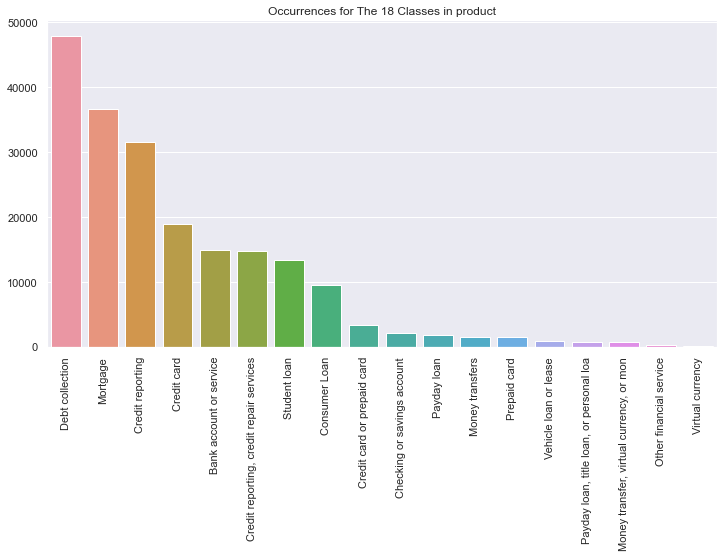

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [10]:
print(x_train.todense()[5].shape)

# OBS: THIS PROCESS MAY TAKE A LONG TIME, MORE THAN 1H
# Creating hyperparameters
penalty_range = ["l2", "l1"]
solver_range = ["saga"]
c_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
param_grid = dict(C=c_range, solver=solver_range, penalty=penalty_range)
cv = KFold(n_splits=3, shuffle=True, random_state=rs)

# Creating model and applying grid search to train model

lr = GridSearchCV(
    estimator=LogisticRegression(max_iter = 500), 
    param_grid=param_grid,
     cv=cv,
     scoring="accuracy",
      verbose=10)
with parallel_backend('threading', n_jobs=2):
    lr.fit(X=x_train, y=ye_train)
    


(1, 1024)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START C=0.001, penalty=l2, solver=saga...........................[CV 2/3; 1/10] START C=0.001, penalty=l2, solver=saga...........................

[CV 1/3; 1/10] END C=0.001, penalty=l2, solver=saga;, score=0.830 total time= 1.2min
[CV 3/3; 1/10] START C=0.001, penalty=l2, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 1/10] END C=0.001, penalty=l2, solver=saga;, score=0.829 total time= 1.3min
[CV 1/3; 2/10] START C=0.001, penalty=l1, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 1/10] END C=0.001, penalty=l2, solver=saga;, score=0.828 total time= 1.3min
[CV 2/3; 2/10] START C=0.001, penalty=l1, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 2/10] END C=0.001, penalty=l1, solver=saga;, score=0.789 total time= 2.3min
[CV 3/3; 2/10] START C=0.001, penalty=l1, solver=saga...........................
[CV 2/3; 2/10] END C=0.001, penalty=l1, solver=saga;, score=0.790 total time= 2.0min
[CV 1/3; 3/10] START C=0.01, penalty=l2, solver=saga............................
[CV 1/3; 3/10] END C=0.01, penalty=l2, solver=saga;, score=0.830 total time= 1.1min
[CV 2/3; 3/10] START C=0.01, penalty=l2, solver=saga............................
[CV 3/3; 2/10] END C=0.001, penalty=l1, solver=saga;, score=0.788 total time= 2.1min
[CV 3/3; 3/10] START C=0.01, penalty=l2, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 3/10] END C=0.01, penalty=l2, solver=saga;, score=0.827 total time= 1.2min
[CV 1/3; 4/10] START C=0.01, penalty=l1, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 3/10] END C=0.01, penalty=l2, solver=saga;, score=0.829 total time= 1.2min
[CV 2/3; 4/10] START C=0.01, penalty=l1, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 4/10] END C=0.01, penalty=l1, solver=saga;, score=0.832 total time= 5.3min
[CV 3/3; 4/10] START C=0.01, penalty=l1, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 4/10] END C=0.01, penalty=l1, solver=saga;, score=0.832 total time= 5.3min
[CV 1/3; 5/10] START C=0.1, penalty=l2, solver=saga.............................
[CV 1/3; 5/10] END C=0.1, penalty=l2, solver=saga;, score=0.829 total time=  53.0s
[CV 2/3; 5/10] START C=0.1, penalty=l2, solver=saga.............................
[CV 2/3; 5/10] END C=0.1, penalty=l2, solver=saga;, score=0.825 total time=  49.4s
[CV 3/3; 5/10] START C=0.1, penalty=l2, solver=saga.............................
[CV 3/3; 5/10] END C=0.1, penalty=l2, solver=saga;, score=0.828 total time=  59.5s
[CV 1/3; 6/10] START C=0.1, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 4/10] END C=0.01, penalty=l1, solver=saga;, score=0.831 total time= 6.0min
[CV 2/3; 6/10] START C=0.1, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 6/10] END C=0.1, penalty=l1, solver=saga;, score=0.832 total time=11.6min
[CV 3/3; 6/10] START C=0.1, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 6/10] END C=0.1, penalty=l1, solver=saga;, score=0.829 total time=11.4min
[CV 1/3; 7/10] START C=1.0, penalty=l2, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 7/10] END C=1.0, penalty=l2, solver=saga;, score=0.829 total time= 1.2min
[CV 2/3; 7/10] START C=1.0, penalty=l2, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 7/10] END C=1.0, penalty=l2, solver=saga;, score=0.826 total time= 1.2min
[CV 3/3; 7/10] START C=1.0, penalty=l2, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 7/10] END C=1.0, penalty=l2, solver=saga;, score=0.828 total time= 1.3min
[CV 1/3; 8/10] START C=1.0, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 6/10] END C=0.1, penalty=l1, solver=saga;, score=0.831 total time=11.2min
[CV 2/3; 8/10] START C=1.0, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 8/10] END C=1.0, penalty=l1, solver=saga;, score=0.829 total time=12.6min
[CV 3/3; 8/10] START C=1.0, penalty=l1, solver=saga.............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 8/10] END C=1.0, penalty=l1, solver=saga;, score=0.827 total time=12.5min
[CV 1/3; 9/10] START C=10.0, penalty=l2, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 9/10] END C=10.0, penalty=l2, solver=saga;, score=0.829 total time= 1.3min
[CV 2/3; 9/10] START C=10.0, penalty=l2, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 9/10] END C=10.0, penalty=l2, solver=saga;, score=0.826 total time= 1.3min
[CV 3/3; 9/10] START C=10.0, penalty=l2, solver=saga............................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 9/10] END C=10.0, penalty=l2, solver=saga;, score=0.828 total time= 1.3min
[CV 1/3; 10/10] START C=10.0, penalty=l1, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 8/10] END C=1.0, penalty=l1, solver=saga;, score=0.828 total time=12.7min
[CV 2/3; 10/10] START C=10.0, penalty=l1, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3; 10/10] END C=10.0, penalty=l1, solver=saga;, score=0.829 total time=12.9min
[CV 3/3; 10/10] START C=10.0, penalty=l1, solver=saga...........................


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3; 10/10] END C=10.0, penalty=l1, solver=saga;, score=0.826 total time=12.8min


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3; 10/10] END C=10.0, penalty=l1, solver=saga;, score=0.828 total time=12.2min


c:\Users\kaleb\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [11]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 0.759
Accuracy (balanced): 0.735


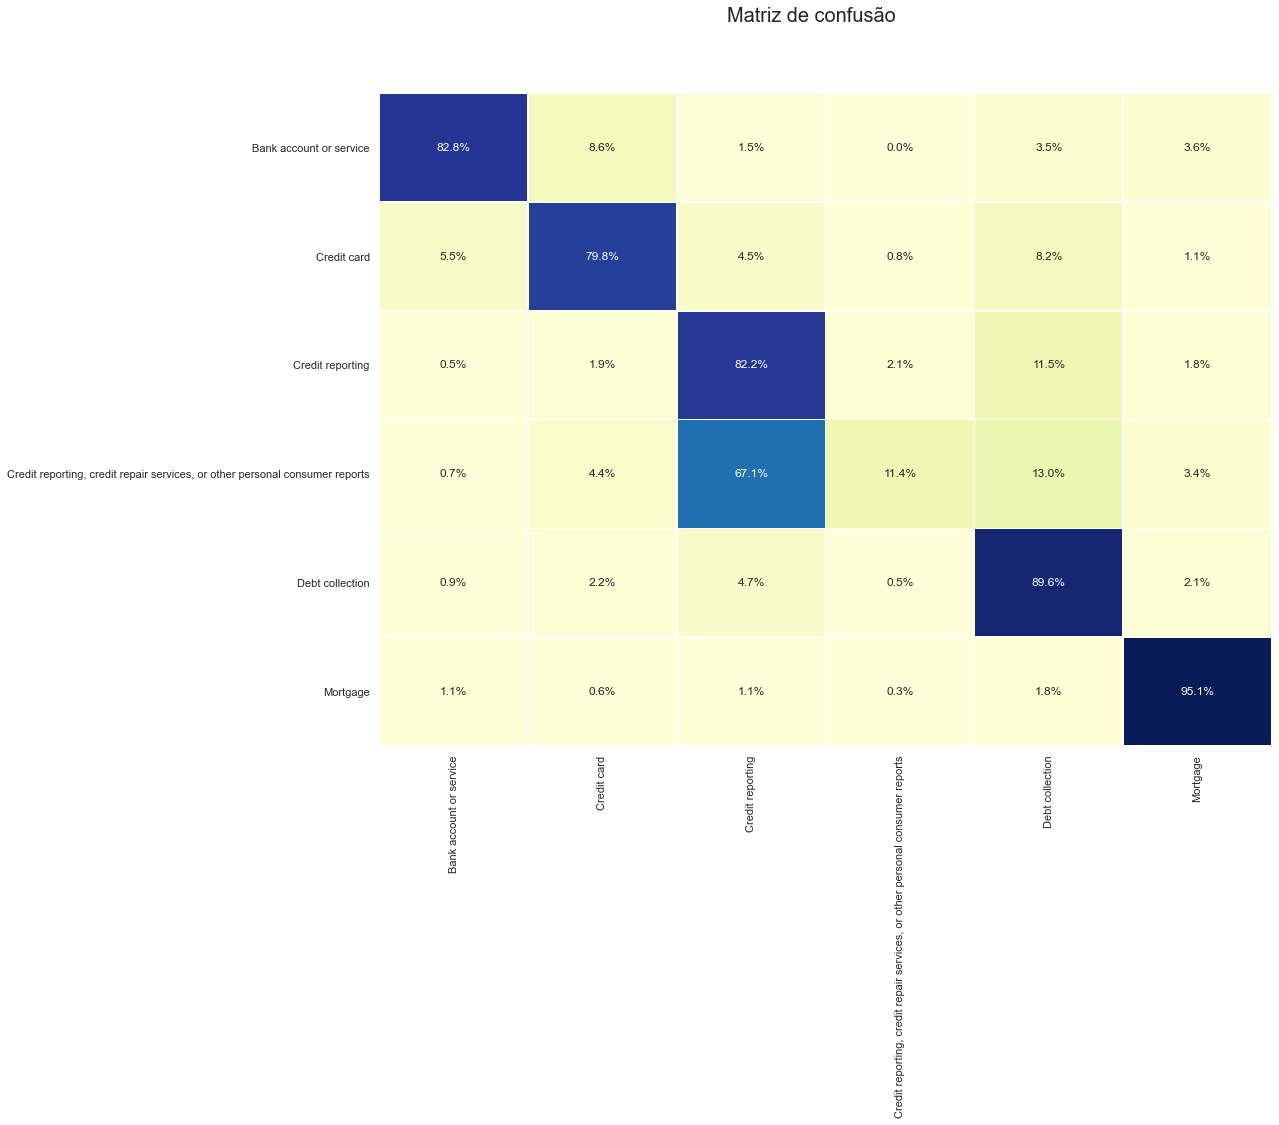

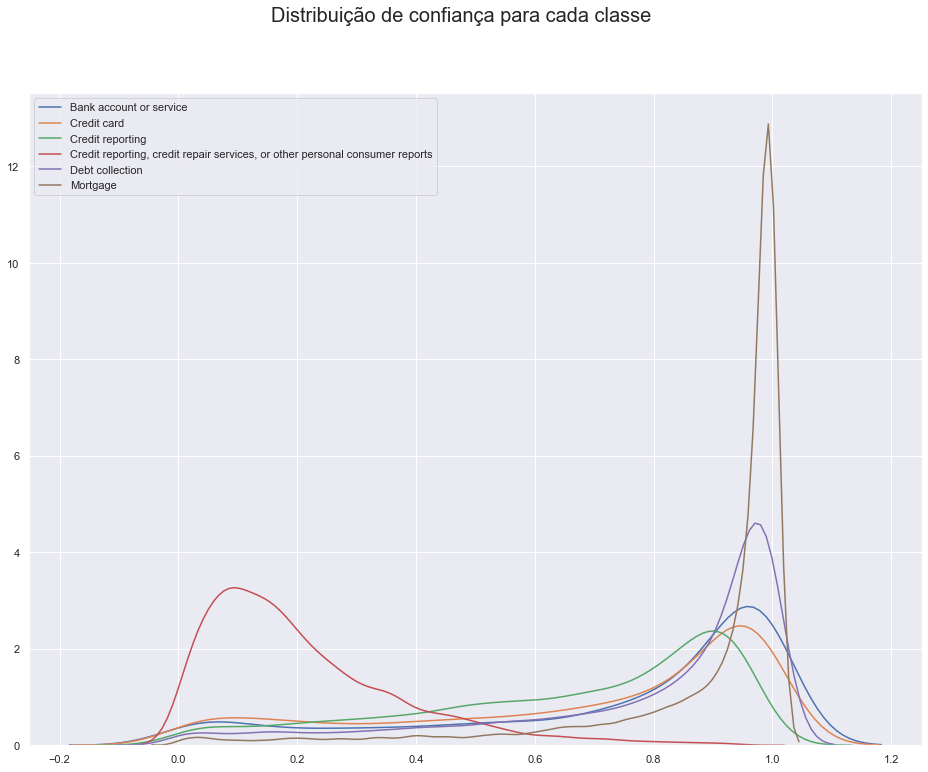

In [12]:
evaluate(ye_test, lr.predict(x_test), lr.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

De todos os resultados apresentados anteriormente, percebemos que, para apenas uma das classes `("Credit reporting, credit repair services, or other personal consumer reports")` tivemos confusão/problemas no momento de realizarmos a previsão. Pelo que nos parece, tal classe representa um subconjunto de uma outra classe extremamente "parecida", a classe `Credit reporting`, o que acaba confundindo o modelo.

Levando em conta o gráfico de distribuição de confiança, percebemos que, a distribuição de confiança para a classe que citamos no parágrafo anterior se mostra isolada/reduzida com relação às outras classes e, podemos afirmar que, esta é a única classe que apresentou baixa confiança no momento da predição, todas as outras classes demostraram alta confiança.

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [13]:
epochs = 20
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [14]:
from keras.utils import np_utils
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [15]:
from keras import Sequential, optimizers
from keras.layers import InputLayer, Dense, Dropout

sgd = optimizers.SGD(learning_rate=0.01) #lr = learning rate

model = Sequential([
    InputLayer((1024,)),
    Dense(512, activation="relu"),
    Dense(100, activation="relu"),
    Dense(6, activation="sigmoid")
])

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [16]:
model.summary()
input_shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 100)               51300     
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 576,706
Trainable params: 576,706
Non-trainable params: 0
_________________________________________________________________


[1024]

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [17]:
import tensorflow as tf
from keras import callbacks
import os
import random as rn
import numpy as np

# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [18]:
device = '/gpu:0'  # ou '/gpu:0'

# Training model with validation split of .25
val_split = .25
with tf.device(device):
    model.fit(x_train.toarray(), y_ohe_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=val_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20
668/675 [============================>.] - ETA: 0s - loss: 0.8268 - categorical_accuracy: 0.7151
Epoch 1: val_loss improved from inf to 1.20568, saving model to weights.h5
675/675 [==============================] - 5s 6ms/step - loss: 0.8244 - categorical_accuracy: 0.7160 - val_loss: 1.2057 - val_categorical_accuracy: 0.6669
Epoch 2/20
665/675 [============================>.] - ETA: 0s - loss: 0.5038 - categorical_accuracy: 0.8400
Epoch 2: val_loss improved from 1.20568 to 1.08360, saving model to weights.h5
675/675 [==============================] - 4s 6ms/step - loss: 0.5032 - categorical_accuracy: 0.8402 - val_loss: 1.0836 - val_categorical_accuracy: 0.6838
Epoch 3/20
670/675 [============================>.] - ETA: 0s - loss: 0.4428 - categorical_accuracy: 0.8589
Epoch 3: val_loss improved from 1.08360 to 1.04405, saving model to weights.h5
675/675 [==============================] - 5s 7ms/step - loss: 0.4431 - categorical_accuracy: 0.8589 - val_loss: 1.0441 - val_categor

In [19]:
# Loading model
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

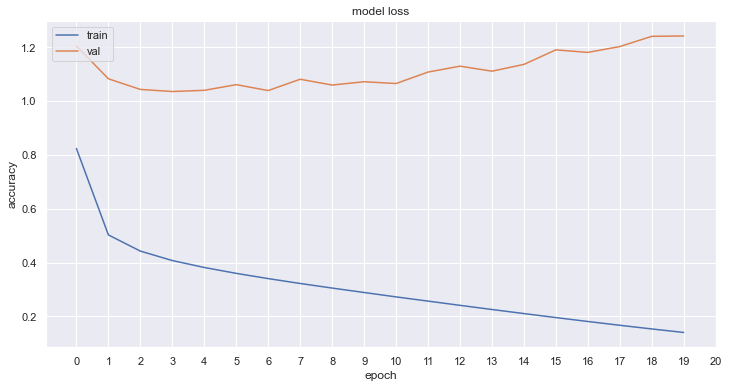

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 21, 1, dtype=int))
plt.show()

Aproximadamente após o epoch = 4 observamos o fenômeno de *overfitting*, dado que o erro no conjunto de validação começa a aumentar.

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

1543/1543 [==============================] - 4s 3ms/step - loss: 0.9345 - categorical_accuracy: 0.7278
Test loss: 0.9345162510871887
Test accuracy (NOT BALANCED): 0.7277646064758301
1543/1543 [==============================] - 4s 3ms/step
Accuracy: 0.728
Accuracy (balanced): 0.7


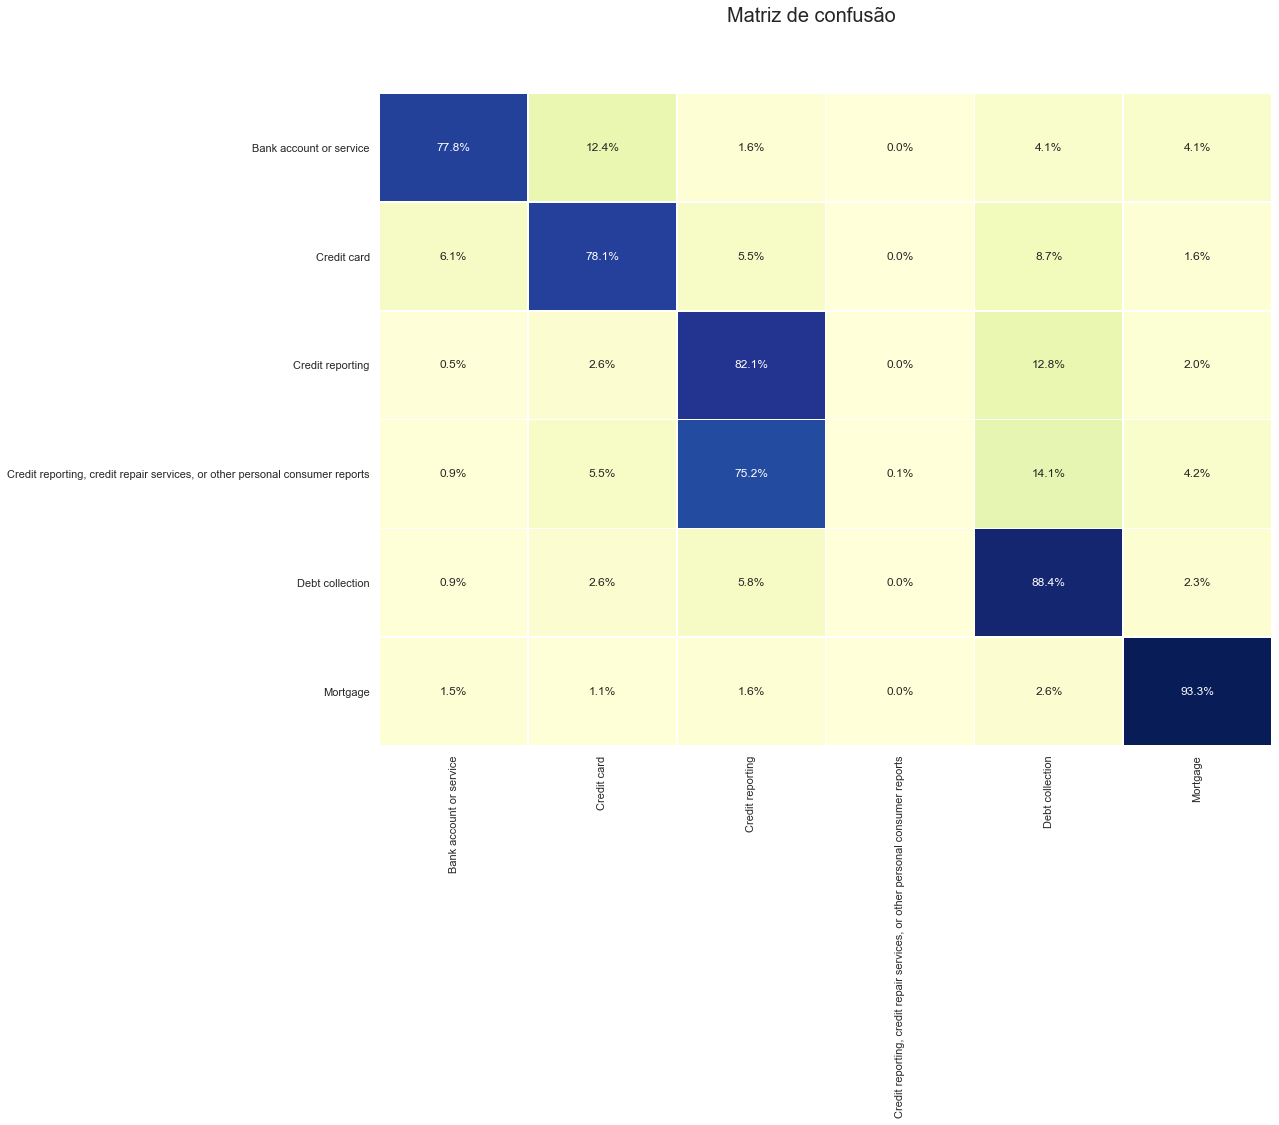

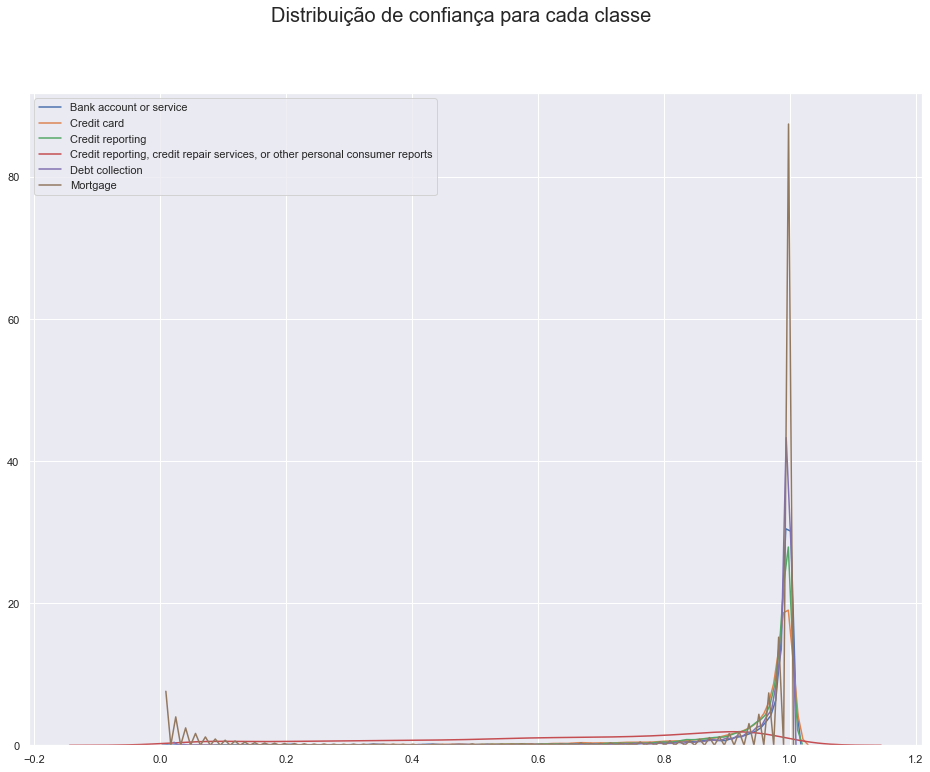

In [21]:
# Searching score
score = model.evaluate(x_test.toarray(), y_ohe_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

# Applying previously calculated function
probs = model.predict(x_test.toarray())
predicted_classes = np.argmax(probs, axis=-1)


evaluate(ye_test, predicted_classes, probs, labels=label_enc.classes_)


--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [22]:
model_complex = Sequential([
    InputLayer((1024,)),
    Dense(800, activation="relu"),
    Dense(600, activation="relu"),
    Dense(400, activation="relu"),
    Dense(200, activation="relu"),
    Dense(100, activation="relu"),
    Dense(50, activation="relu"),
    Dense(6, activation="sigmoid")
])

model_complex.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

**Atividade (1 pt):** treine a nova rede.

In [23]:
# Training model with validation split
with tf.device(device):
    model_complex.fit(x_train.toarray(), y_ohe_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=val_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights_complex.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20
672/675 [============================>.] - ETA: 0s - loss: 0.9898 - categorical_accuracy: 0.6324
Epoch 1: val_loss improved from inf to 1.16964, saving model to weights_complex.h5
675/675 [==============================] - 9s 13ms/step - loss: 0.9885 - categorical_accuracy: 0.6329 - val_loss: 1.1696 - val_categorical_accuracy: 0.6573
Epoch 2/20
670/675 [============================>.] - ETA: 0s - loss: 0.5057 - categorical_accuracy: 0.8363
Epoch 2: val_loss improved from 1.16964 to 1.04731, saving model to weights_complex.h5
675/675 [==============================] - 8s 12ms/step - loss: 0.5054 - categorical_accuracy: 0.8365 - val_loss: 1.0473 - val_categorical_accuracy: 0.6877
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.4309 - categorical_accuracy: 0.8618
Epoch 3: val_loss improved from 1.04731 to 1.01470, saving model to weights_complex.h5
675/675 [==============================] - 7s 11ms/step - loss: 0.4309 - categorical_accuracy: 0.8618 - val

In [24]:
# Loading from file
model_complex.load_weights('weights_complex.h5')

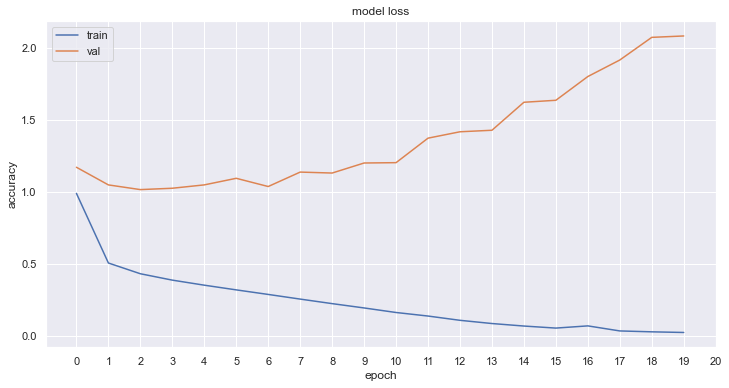

In [25]:
plt.plot(model_complex.history.history['loss'])
plt.plot(model_complex.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 21, 1, dtype=int))
plt.show()

1543/1543 [==============================] - 5s 3ms/step - loss: 0.9098 - categorical_accuracy: 0.7242
Test loss: 0.9097656607627869
Test accuracy (NOT BALANCED): 0.7242183089256287
1543/1543 [==============================] - 5s 3ms/step
Accuracy: 0.724
Accuracy (balanced): 0.696


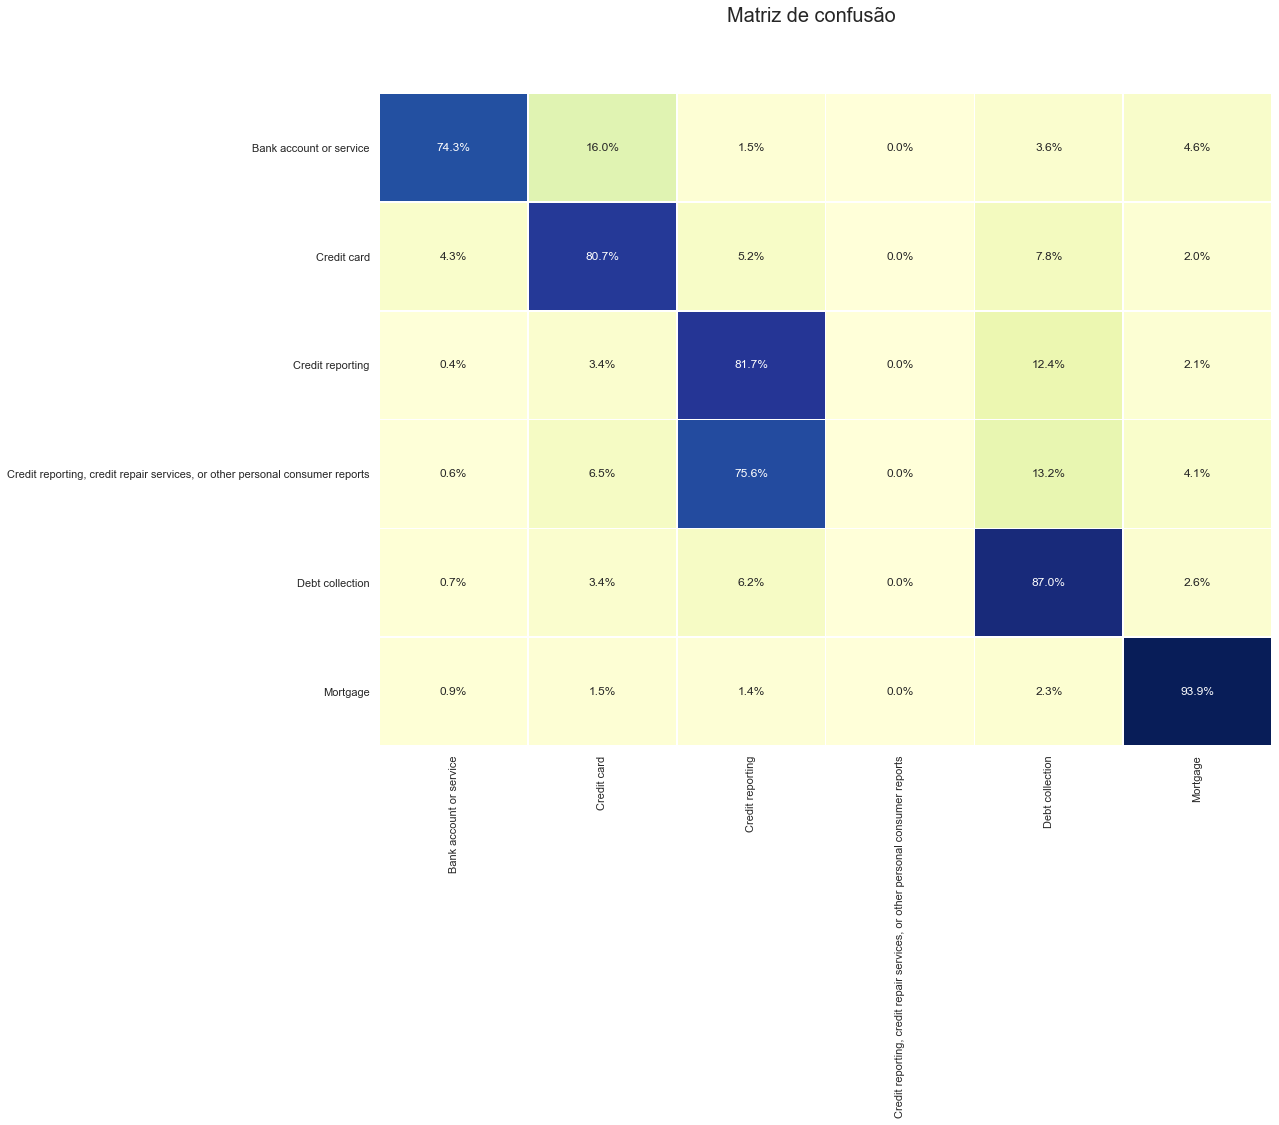

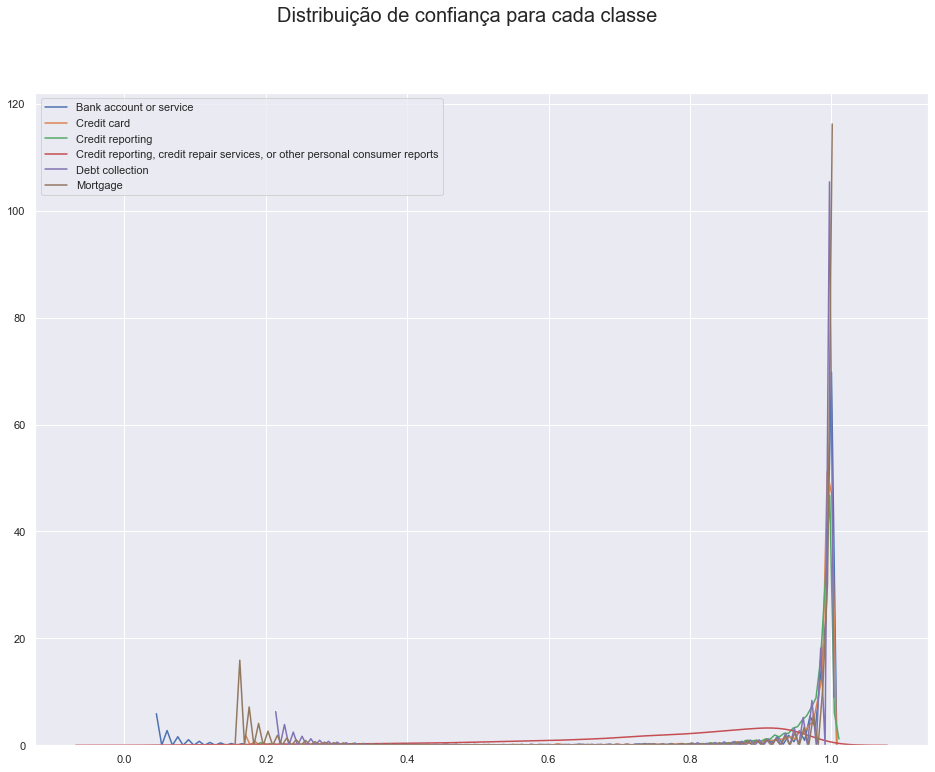

In [26]:
# Searching score
score_complex = model_complex.evaluate(x_test.toarray(), y_ohe_test, verbose=1)
print('Test loss:', score_complex[0])
print('Test accuracy (NOT BALANCED):', score_complex[1])

# Applying previously calculated function
probs_complex = model_complex.predict(x_test.toarray())
predicted_classes_complex = np.argmax(probs_complex, axis=-1)


evaluate(ye_test, predicted_classes_complex, probs_complex, labels=label_enc.classes_)

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [27]:
model_complex_dropout = Sequential([
    InputLayer((1024,)),
    Dense(800, activation="relu"),
    Dropout(0.2),
    Dense(600, activation="relu"),
    Dense(400, activation="relu"),
    Dropout(0.2),
    Dense(200, activation="relu"),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(6, activation="sigmoid")
])

model_complex_dropout.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [28]:
device = '/gpu:0'  # ou '/gpu:0'

# Training model with validation split of .25
val_split = .25
with tf.device(device):
    model_complex_dropout.fit(x_train.toarray(), y_ohe_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=val_split,
              verbose=1,
              callbacks=[
                  callbacks.TerminateOnNaN(),
                  callbacks.ModelCheckpoint('weights_complex_dropout.h5',
                                            save_best_only=True,
                                            verbose=1),
              ])

Epoch 1/20
673/675 [============================>.] - ETA: 0s - loss: 1.2838 - categorical_accuracy: 0.4893
Epoch 1: val_loss improved from inf to 1.35410, saving model to weights_complex_dropout.h5
675/675 [==============================] - 11s 14ms/step - loss: 1.2827 - categorical_accuracy: 0.4898 - val_loss: 1.3541 - val_categorical_accuracy: 0.6399
Epoch 2/20
673/675 [============================>.] - ETA: 0s - loss: 0.6924 - categorical_accuracy: 0.7686
Epoch 2: val_loss improved from 1.35410 to 1.03921, saving model to weights_complex_dropout.h5
675/675 [==============================] - 10s 15ms/step - loss: 0.6922 - categorical_accuracy: 0.7687 - val_loss: 1.0392 - val_categorical_accuracy: 0.6788
Epoch 3/20
671/675 [============================>.] - ETA: 0s - loss: 0.5657 - categorical_accuracy: 0.8181
Epoch 3: val_loss improved from 1.03921 to 0.99040, saving model to weights_complex_dropout.h5
675/675 [==============================] - 9s 13ms/step - loss: 0.5656 - categori

In [29]:
# Loading from file
model_complex_dropout.load_weights('weights_complex_dropout.h5')

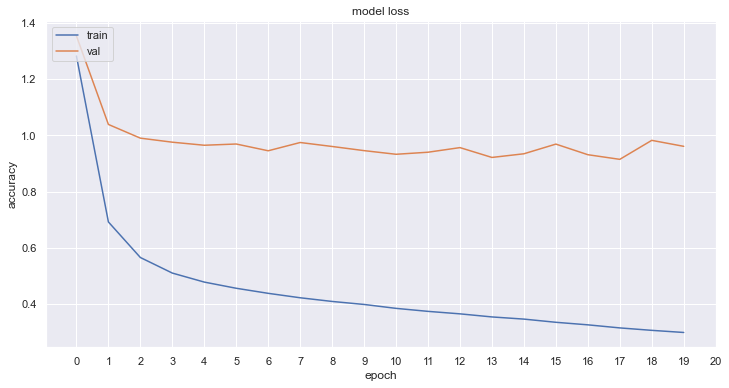

In [30]:
plt.plot(model_complex_dropout.history.history['loss'])
plt.plot(model_complex_dropout.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, 21, 1, dtype=int))
plt.show()

1543/1543 [==============================] - 7s 4ms/step - loss: 0.8420 - categorical_accuracy: 0.7382
Test loss: 0.8419774770736694
Test accuracy (NOT BALANCED): 0.7382009029388428
1543/1543 [==============================] - 7s 4ms/step
Accuracy: 0.738
Accuracy (balanced): 0.714


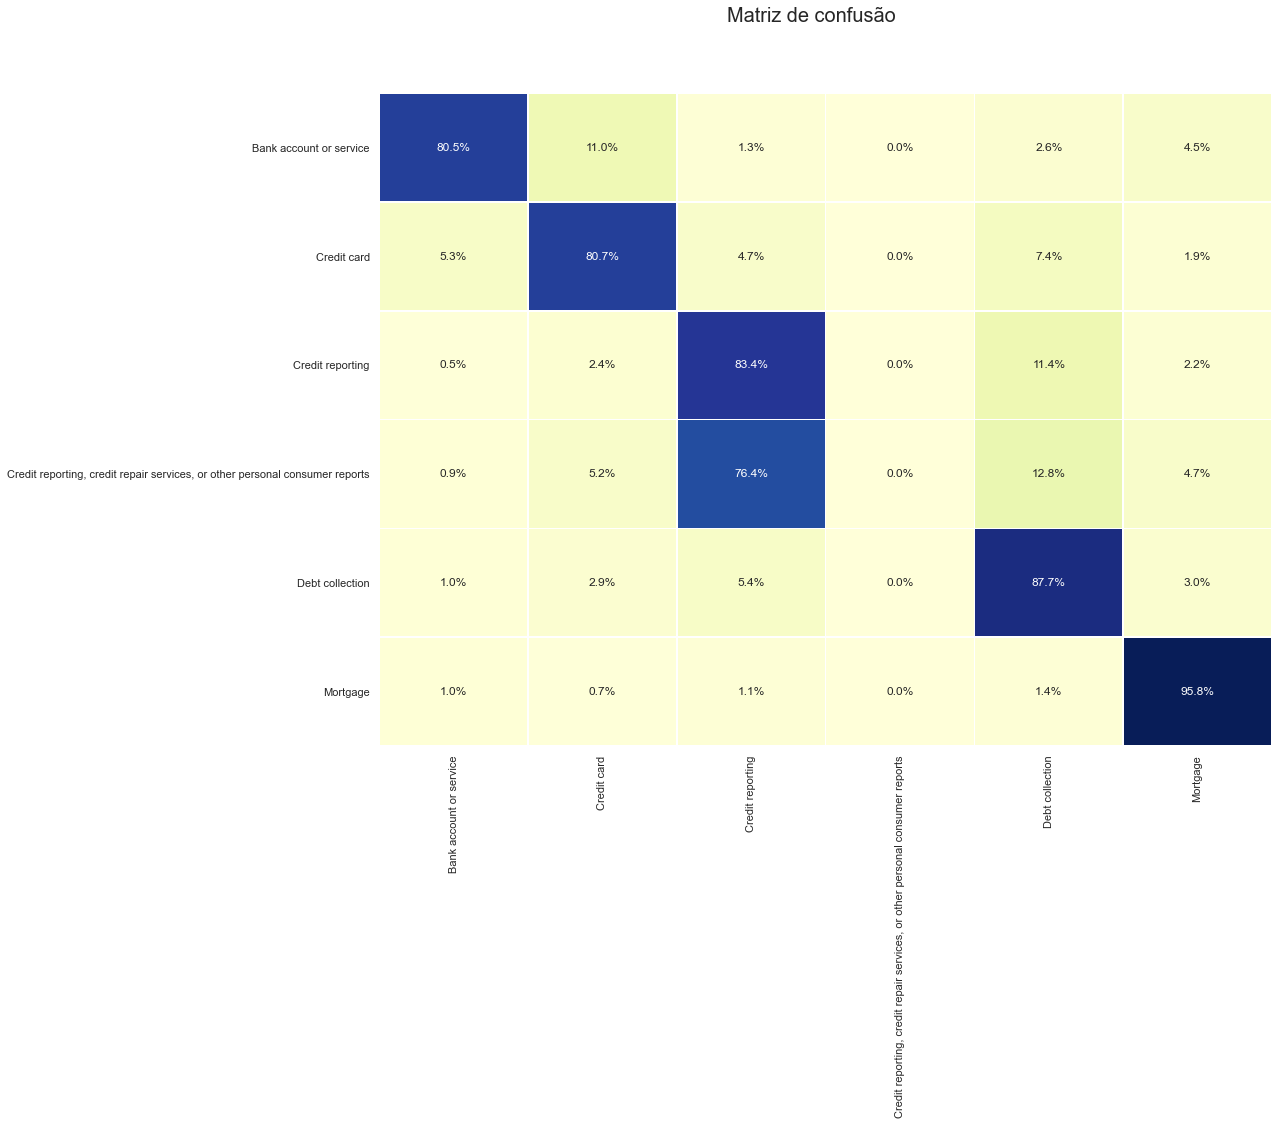

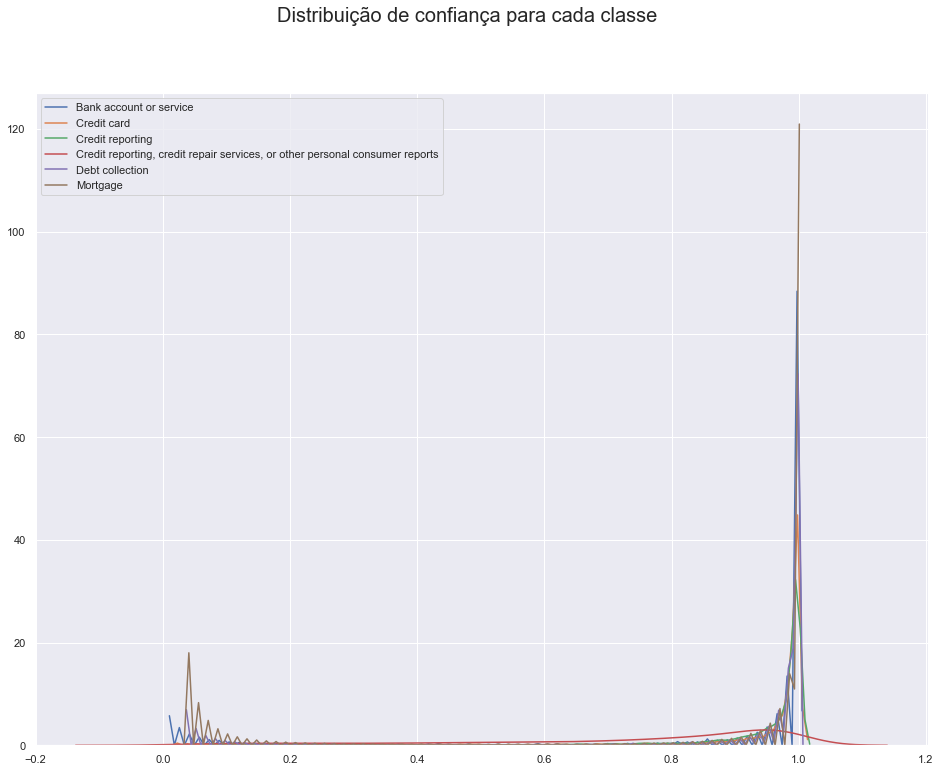

In [31]:
# Searching score
score_complex_dropout = model_complex_dropout.evaluate(x_test.toarray(), y_ohe_test, verbose=1)
print('Test loss:', score_complex_dropout[0])
print('Test accuracy (NOT BALANCED):', score_complex_dropout[1])

# Applying previously calculated function
probs_complex_dropout = model_complex_dropout.predict(x_test.toarray())
predicted_classes_complex_dropout = np.argmax(probs_complex_dropout, axis=-1)


evaluate(ye_test, predicted_classes_complex_dropout, probs_complex_dropout, labels=label_enc.classes_)

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

Observamos que, **dentre os modelos de redes neurais**, o melhor modelo apresentado, se mostrou como o modelo de `Dropout`, apresentando maior acurácia balanceada no conjunto de testes (0.714). Note que, não utilizamos o conjunto de testes em nenhum momento para *hyperparameter tuning*, apenas avaliamos os modelos em tal dataset. No que diz respeito ao `Dropout`, todas as conexões da nossa rede (no ponto da rede em que o  `Dropout` foi inserido) num dado neurônio são "removidas" momentaneamente. Os neurônios são removidos com probabilidade $p$ num dado ponto da nossa rede, eventualmente, evitando o aprendizado do que é conhecido como `Statistical noise`, implicando numa menor taxa de `overfitting`.

No entanto, o melhor modelo globalmente apresentado, se mostrou como o modelo de regressão logística, apresentando acurácia balanceada no conjunto de testes de 0.735. Note que, todos os modelos apresentados neste trabalho "confundiram" a classe `"Credit reporting, credit repair services, or other personal consumer reports"` com a classe `Credit reporting`, dado que podemos considerar uma classe como subconjunto da outra e, abstraindo, podemos pensar que uma é linearmente dependente da outra o que acarreta na confusão dos métodos de otimização, evidenciados nos *warnings* recebidos ao usar o SAGA, por exemplo.

Note ainda que a matriz de confusão para as duas últimas redes que treinamos `model_complex` e `model_complex_dropout` foram tais que nenhum elemento foi classificado como  `"Credit reporting, credit repair services, or other personal consumer reports"`, evidenciando o que comentamos anteriormente sobre os problemas obtidos utilizando esta classe.